In [2]:
# Импорт библиотек, загрузка данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
import os
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

import os

nltk.download('stopwords')

# Загрузка данных
csv_path = '88005553535.csv'
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(df.head())
    df.info(verbose=True)
else:
    print(f"Файл '{csv_path}' не найден.")


   annotation_id  annotator                                       comment  \
0             16          2                                       спасибо   
1             17          2                                      спасибо!   
2             18          2                                      Отлично    
3             19          2  Благодарю за оперативное решение проблемы !    
4             20          2         Прекрасный специалист! Побольше таких   

                    created_at       id  lead_time  rating  \
0  2025-05-08T12:32:06.806278Z  2945792     49.604       5   
1  2025-05-08T12:44:25.556719Z  3234340      2.058       5   
2  2025-05-08T12:44:46.429049Z  3380332     19.677       5   
3  2025-05-08T12:45:09.100228Z  3381812     21.395       5   
4  2025-05-08T12:45:23.515860Z  3461991     13.272       5   

                                           sentiment  \
0                                       Вопрос решен   
1                                       Вопрос решен

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Предварительная обработка данных
# Очистка и предварительная обработка текста
stop_words = set(stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Удаление спецсимволов и цифр
    text = re.sub(r'[^а-яА-ЯёЁ\s]', '', text.lower())
    # Удаление стоп-слов и стемминг
    words = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)

# Применение очистки к комментариям
df['cleaned_comment'] = df['comment'].apply(clean_text)

# Извлечение меток из поля sentiment
def extract_labels(sentiment):
    if pd.isna(sentiment):
        return []
    if sentiment == "Вопрос решен":
        return ["Вопрос решен"]
    if sentiment == "ни к одному из перечисленных":
        return ["Другое"]
    if sentiment.startswith('{"choices":'):
        import json
        try:
            labels = json.loads(sentiment.replace("'", '"'))['choices']
            return [label.strip() for label in labels]
        except:
            return []
    return []

# Создание бинарных меток для каждой категории
categories = [
    "Нравится скорость отработки заявок",
    "Нравится качество выполнения заявки",
    "Нравится качество работы сотрудников",
    "Понравилось выполнение заявки",
    "Вопрос решен",
    "Другое"
]

mlb = MultiLabelBinarizer(classes=categories)
labels = mlb.fit_transform(df['sentiment'].apply(extract_labels))

# Создание DataFrame с метками
labels_df = pd.DataFrame(labels, columns=categories)

# Добавление рейтинга как дополнительной фичи
df['rating'] = df['rating'].fillna(3)  # Заполнение пропусков средним значением

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ни к одному из перечисленных'] will be ignored
  warnings.warn(


In [4]:
# Разделение данных и создание пайплайна
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_comment'],
    labels_df,
    test_size=0.3,
    random_state=42
)

# Создание пайплайна с TF-IDF и классификатором
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', MultiOutputClassifier(
        LogisticRegression(max_iter=1000, class_weight='balanced', C=0.1, solver='saga'),
        n_jobs=-1
    ))
])

# Обучение модели
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(C=0.1,
                                                                    class_weight='balanced',
                                                                    max_iter=1000,
                                                                    solver='saga'),
                                       n_jobs=-1))])

In [5]:
# Оценка модели
# Предсказание на тестовых данных
y_pred_proba = pipeline.predict_proba(X_test)
# Используем X_test для предсказания, а не индексы y_test
y_pred = pipeline.predict(X_test)

# Вычисление ROC-AUC для каждой категории
roc_auc_scores = {}
for i, category in enumerate(categories):
    roc_auc = roc_auc_score(y_test[category], y_pred_proba[i][:, 1])
    roc_auc_scores[category] = roc_auc
    print(f"ROC-AUC for {category}: {roc_auc:.4f}")


# Отчет по классификации
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

# Проверка на переобучение
y_train_pred_proba = pipeline.predict_proba(X_train)
train_roc_auc_scores = {}
for i, category in enumerate(categories):
    roc_auc = roc_auc_score(y_train[category], y_train_pred_proba[i][:, 1])
    train_roc_auc_scores[category] = roc_auc

print("\nTrain ROC-AUC Scores:")
for category, score in train_roc_auc_scores.items():
    print(f"{category}: {score:.4f}")

# Разница между train и test ROC-AUC
print("\nOverfitting Check (Train - Test ROC-AUC):")
for category in categories:
    diff = train_roc_auc_scores[category] - roc_auc_scores[category]
    print(f"{category}: {diff:.4f}")

ROC-AUC for Нравится скорость отработки заявок: 0.9744
ROC-AUC for Нравится качество выполнения заявки: 0.9476
ROC-AUC for Нравится качество работы сотрудников: 0.8580
ROC-AUC for Понравилось выполнение заявки: 0.8548
ROC-AUC for Вопрос решен: 0.9145
ROC-AUC for Другое: 0.9784

Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок       0.91      0.93      0.92       260
 Нравится качество выполнения заявки       0.55      0.77      0.64        48
Нравится качество работы сотрудников       0.34      0.83      0.48       121
       Понравилось выполнение заявки       0.48      0.70      0.57       129
                        Вопрос решен       0.99      0.78      0.87       627
                              Другое       0.37      0.99      0.54        67

                           micro avg       0.69      0.82      0.75      1252
                           macro avg       0.61      0.83      0.67     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
# Загрузка нового набора данных


new_csv_path = 'разметка комментариев 2.csv'  # Укажите путь к вашему новому файлу
if os.path.exists(new_csv_path):
    df_new = pd.read_csv(new_csv_path)
    print(f"Файл '{new_csv_path}' успешно загружен.")
    print(df_new.head())
    df_new.info(verbose=True)
else:
    print(f"Файл '{new_csv_path}' не найден.")
    # Можно выйти или поднять исключение, если файл обязателен
    exit() # Остановить выполнение, если файл не найден

# Предварительная обработка нового набора данных
# Убедитесь, что столбец с комментариями называется 'comment'
comment_column_name_new_data = 'comment' # Проверьте, если имя столбца отличается, измените его здесь

if comment_column_name_new_data in df_new.columns:
    # Убедитесь, что функция clean_text определена
    if 'clean_text' in globals():
        df_new['cleaned_comment'] = df_new[comment_column_name_new_data].apply(clean_text)
    else:
        print("Ошибка: Функция clean_text не определена. Убедитесь, что предыдущие ячейки были выполнены.")
        exit()
else:
    print(f"Ошибка: Столбец '{comment_column_name_new_data}' не найден в новом файле.")
    exit() # Остановить выполнение, если нет столбца с комментариями

# Создание DataFrame с метками для нового набора данных
# В новом файле метки уже представлены отдельными столбцами
# Убедитесь, что названия столбцов в новом файле соответствуют названиям в списке categories
# Если названия отличаются, вам нужно будет переименовать столбцы в df_new
# Например: df_new.rename(columns={'старое_название': 'новое_название'}, inplace=True)

# Проверка наличия всех категорий как столбцов в новом DataFrame
# Убедитесь, что список categories определен
if 'categories' in globals():
    missing_categories = [cat for cat in categories if cat not in df_new.columns]
    if missing_categories:
        print(f"В новом файле отсутствуют столбцы для следующих категорий: {missing_categories}. Добавляем их со значениями 0.")
        # Добавляем отсутствующие столбцы и заполняем их нулями
        for cat in missing_categories:
            df_new[cat] = 0
        # exit() # В данном случае не выходим, а добавляем отсутствующие столбцы

    # Выбираем столбцы, соответствующие категориям, для создания labels_df_new
    # После добавления отсутствующих столбцов, все категории должны присутствовать
    labels_df_new = df_new[categories].copy()

    # *** ДОБАВЛЕННЫЙ КОД: Заполняем NaN в labels_df_new нулями перед преобразованием в int ***
    labels_df_new.fillna(0, inplace=True)


else:
    print("Ошибка: Список categories не определен. Убедитесь, что предыдущие ячейки были выполнены.")
    exit()


# Применение пайплайна к новым данным для предсказания вероятностей
# Убедитесь, что столбец 'cleaned_comment' был успешно создан
# Убедитесь, что pipeline обучен
if 'cleaned_comment' in df_new.columns:
    if 'pipeline' in globals() and pipeline:
        y_pred_proba_new = pipeline.predict_proba(df_new['cleaned_comment'])

        # Предсказание бинарных меток
        y_pred_new = pipeline.predict(df_new['cleaned_comment'])

        # Оценка производительности модели на новом наборе данных
        print("\nОценка производительности на новом наборе данных:")

        # Вычисление ROC-AUC для каждой категории на новом наборе данных
        roc_auc_scores_new = {}
        for i, category in enumerate(categories):
            # Убедитесь, что в новом наборе данных есть образцы для этой категории в labels_df_new
            # Также убедитесь, что столбец содержит числовые значения (0 или 1)
            # Если столбец добавлен со значениями 0, np.sum будет 0, и ROC-AUC нельзя вычислить.
            # Проверяем, что есть как минимум одно положительное значение в истинных метках
            # Используем .astype(int) здесь тоже, после заполнения NaN
            if labels_df_new[category].sum() > 0:
                try:
                    # Убедитесь, что данные в labels_df_new[category] имеют числовой тип (0 or 1)
                    roc_auc = roc_auc_score(labels_df_new[category].astype(int), y_pred_proba_new[i][:, 1])
                    roc_auc_scores_new[category] = roc_auc
                    print(f"ROC-AUC для {category}: {roc_auc:.4f}")
                except ValueError as e:
                    print(f"Не удалось вычислить ROC-AUC для категории '{category}': {e}")
                    print(f"Проверьте значения в столбце '{category}' в labels_df_new. Они должны быть 0 или 1.")
            else:
                print(f"Недостаточно образцов с меткой 1 для категории '{category}' в новом наборе данных для вычисления ROC-AUC.")


        # Отчет по классификации на новом наборе данных
        print("\nClassification Report (New Data):")
        # Classification report также ожидает бинарные метки.
        # Убедитесь, что labels_df_new имеет числовой тип
        # Import classification_report if not already imported in this block
        from sklearn.metrics import classification_report # Ensure this is imported here if not globally

        # *** ИСПОЛЬЗУЕМ labels_df_new после fillna(0) перед astype(int) ***
        print(classification_report(labels_df_new.astype(int), y_pred_new, target_names=categories, zero_division=0))

        # Другие метрики на новом наборе данных
        # Import necessary metrics from sklearn if not already imported
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

        try:
            # *** ИСПОЛЬЗУЕМ labels_df_new после fillna(0) перед astype(int) ***
            accuracy_new = accuracy_score(labels_df_new.astype(int), y_pred_new)
            print(f"Accuracy (New Data): {accuracy_new:.4f}")

            # *** ИСПОЛЬЗУЕМ labels_df_new после fillna(0) перед astype(int) ***
            precision_weighted_new = precision_score(labels_df_new.astype(int), y_pred_new, average='weighted', zero_division=0)
            print(f"Precision (New Data): {precision_weighted_new:.4f}")

            # *** ИСПОЛЬЗУЕМ labels_df_new после fillna(0) перед astype(int) ***
            recall_weighted_new = recall_score(labels_df_new.astype(int), y_pred_new, average='weighted', zero_division=0)
            print(f"Recall (New Data): {recall_weighted_new:.4f}")

            # *** ИСПОЛЬЗУЕМ labels_df_new после fillna(0) перед astype(int) ***
            f1_weighted_new = f1_score(labels_df_new.astype(int), y_pred_new, average='weighted', zero_division=0)
            print(f"F1-Score (New Data): {f1_weighted_new:.4f}")
        except ValueError as e:
            print(f"Ошибка при вычислении метрик на новом наборе данных: {e}")
            print("Убедитесь, что labels_df_new и y_pred_new содержат числовые (бинарные) значения.")
    else:
         print("Ошибка: Пайплайн не определен или не обучен. Убедитесь, что предыдущие ячейки были выполнены.")
         exit()
else:
    print("Невозможно выполнить предсказание, так как столбец 'cleaned_comment' отсутствует.")

Файл 'разметка комментариев 2.csv' успешно загружен.
        id  rating                                       comment  \
0  2945792       5                                       спасибо   
1  3234340       5                                      спасибо!   
2  3380332       5                                      Отлично    
3  3381812       5  Благодарю за оперативное решение проблемы !    
4  3461991       5         Прекрасный специалист! Побольше таких   

   Нравится скорость отработки заявок  Нравится качество выполнения заявки  \
0                                 NaN                                  NaN   
1                                 NaN                                  NaN   
2                                 NaN                                  NaN   
3                                 NaN                                  NaN   
4                                 NaN                                  NaN   

   Нравится качество работы сотрудников  Понравилось выполнение заявк

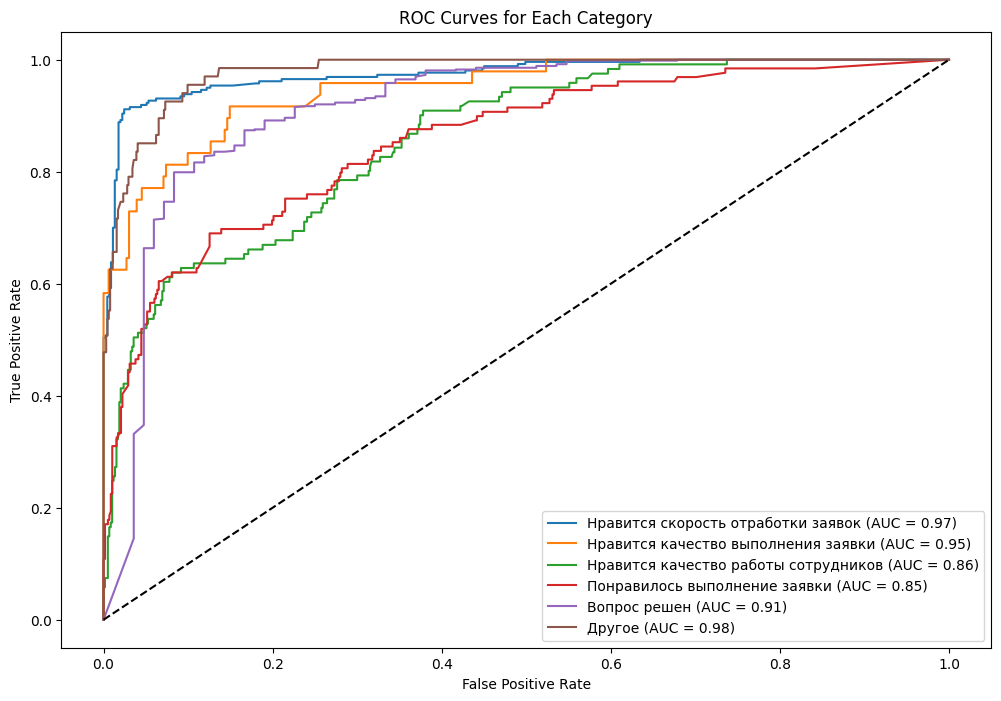


Micro ROC-AUC: 0.9207
Macro ROC-AUC: 0.9213
Accuracy: 0.5120
Precision: 0.8061
Recall: 0.8187
F1-Score: 0.7866


In [8]:
# Визуализация ROC-кривых
# ROC-кривые для каждой категории
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    fpr, tpr, _ = roc_curve(y_test[category], y_pred_proba[i][:, 1])
    plt.plot(fpr, tpr, label=f'{category} (AUC = {roc_auc_scores[category]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Category')
plt.legend(loc='lower right')
plt.show()



# Micro ROC-AUC
y_test_micro = y_test.values.ravel()
y_pred_proba_micro = np.vstack([y_pred_proba[i][:, 1] for i in range(len(categories))]).T.ravel()
roc_auc_micro = roc_auc_score(y_test_micro, y_pred_proba_micro)
print(f"\nMicro ROC-AUC: {roc_auc_micro:.4f}")

# Macro ROC-AUC
macro_roc_auc = np.mean(list(roc_auc_scores.values()))
print(f"Macro ROC-AUC: {macro_roc_auc:.4f}")

# Import necessary metrics from sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision_weighted = precision_score(y_test, y_pred, average='weighted') # Добавлен weighted
print(f"Precision: {precision_weighted:.4f}") # Вывод weighted

# Recall
recall_weighted = recall_score(y_test, y_pred, average='weighted') # Добавлен weighted
print(f"Recall: {recall_weighted:.4f}") # Вывод weighted

# F1-Score
f1_weighted = f1_score(y_test, y_pred, average='weighted') # Добавлен weighted
print(f"F1-Score: {f1_weighted:.4f}") # Вывод weighted

In [9]:
# Предположим, у вас есть новый текст для предсказания
new_comment_text = "Спасибо"

# Создание DataFrame из нового текста
# Pipeline ожидает серию или DataFrame, поэтому создаем его
df_single_comment = pd.DataFrame({'comment': [new_comment_text]})

# Предварительная обработка нового текста
# Убедитесь, что функция clean_text определена и доступна (т.е. ячейка с ней выполнена)
if 'clean_text' in globals():
    df_single_comment['cleaned_comment'] = df_single_comment['comment'].apply(clean_text)

    # Проверка, что столбец 'cleaned_comment' не пустой после обработки
    if not df_single_comment['cleaned_comment'].empty and df_single_comment['cleaned_comment'].iloc[0] != "":
        # Применение обученного пайплайна для предсказания
        # Убедитесь, что pipeline обучен и доступен (т.е. ячейка с обучением выполнена)
        if 'pipeline' in globals() and pipeline:
            # Предсказание вероятностей для каждой категории
            # predict_proba возвращает список массивов, по одному массиву на каждый класс
            # Для MultiOutputClassifier predict_proba возвращает список из результатов predict_proba для каждого классификатора
            # Каждый элемент списка - это массив формы (n_samples, n_classes_in_classifier)
            # Так как каждый классификатор бинарный, n_classes_in_classifier = 2 (вероятность 0 и вероятность 1)
            y_pred_proba_single = pipeline.predict_proba(df_single_comment['cleaned_comment'])

            # Предсказание бинарных меток
            # predict возвращает массив бинарных меток формы (n_samples, n_output)
            y_pred_single = pipeline.predict(df_single_comment['cleaned_comment'])

            # Вывод результатов
            print(f"\nПредсказания для текста: '{new_comment_text}'")

            # Вывод вероятностей
            print("\nВероятности для каждой категории:")
            # y_pred_proba_single - это список, где y_pred_proba_single[i] - это массив вероятностей для i-й категории
            # Нам нужна вероятность класса 1, которая находится во втором столбце [:, 1]
            for i, category in enumerate(categories):
                 # Проверяем, что predict_proba вернул ожидаемую структуру
                 if i < len(y_pred_proba_single) and y_pred_proba_single[i].shape[1] > 1:
                    print(f"- {category}: {y_pred_proba_single[i][0, 1]:.4f}")
                 else:
                    print(f"- Не удалось получить вероятность для категории '{category}'.")


            # Вывод предсказанных бинарных меток
            print("\nПредсказанные бинарные метки:")
            # y_pred_single - это массив, где y_pred_single[0] содержит бинарные метки для первого (и единственного) образца
            predicted_labels = [categories[j] for j, label in enumerate(y_pred_single[0]) if label == 1]
            if predicted_labels:
                print(f"- {', '.join(predicted_labels)}")
            else:
                print("- Не было предсказано ни одной категории.")

        else:
             print("Ошибка: Пайплайн не определен или не обучен. Убедитесь, что предыдущие ячейки были выполнены.")
    else:
        print("Ошибка: Обработанный комментарий пуст. Проверьте входной текст и функцию clean_text.")
else:
    print("Ошибка: Функция clean_text не определена. Убедитесь, что предыдущие ячейки были выполнены.")


Предсказания для текста: 'Спасибо'

Вероятности для каждой категории:
- Нравится скорость отработки заявок: 0.1190
- Нравится качество выполнения заявки: 0.1114
- Нравится качество работы сотрудников: 0.1348
- Понравилось выполнение заявки: 0.1462
- Вопрос решен: 0.8847
- Другое: 0.0810

Предсказанные бинарные метки:
- Вопрос решен
